# <center>非負値行列因子分解NMF</center>

行列の扱いの練習として、非負値行列因子分解の詳細を理解してみよう。

## 欠損値のある場合の非負値行列因子分解

https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf

行列因子分解では、関心のある行列$X$が二つの(長方形)行列の積で表されていると仮定する：

$$
X\approx WH
$$

今回は、この$X$の成分の一部が欠損している時、そこを補完する機械学習手法である非負値行列因子分解を理解する。

行列の要素のうち、欠損のある部分を指し示すマスクを$m_{ij}$とする：

$$
m_{ij}=\left\{
\begin{array}{ll}
0 \quad x_{ij}=None\\
1 \quad otherwise
\end{array}
\right.
$$

そこで$X\approx WH$という行列分解を与える$W$と$H$を学習させて、そのついでに欠損値も補うことを考える。そのために、欠損値以外の場所で$X$と$WH$が近づくように、次の目的関数を最小化することを考えよう：
$$
L=
\frac{1}{2}
\|M\odot(X-WH)\|^2_F
=
\frac{1}{2}
\sum_{i,j}m_{ij}\left(x_{ij}-
\sum_kw_{ik}h_{kj}\right)^2
$$

行列のフロベニウムノルム$\|\|^2_F$は、行列の各要素の二乗和のことである。

# アルゴリズムの導出

$\sum_kc_k=1$なる任意の係数を用いると、二次関数は下に凸なので
$$
\left(
\sum_kw_{ik}h_{kj}\right)^2
=
\left(
\sum_kc_k
\frac{w_{ik}h_{kj}}{c_k}
\right)^2
\leq
\sum_kc_k
\left(\frac{w_{ik}h_{kj}}{c_k}
\right)^2
$$


すると目的関数$L\geq0$は次の様に上から押さえられる
$$
L
=
\frac{1}{2}
\sum_{i,j}m_{ij}\left(x_{ij}^2
-2
x_{ij}
\sum_kw_{ik}h_{kj}
+
\left(\sum_kw_{ik}h_{kj}\right)^2\right)
\leq
\frac{1}{2}
\sum_{i,j}m_{ij}\left(x_{ij}^2
-2
x_{ij}
\sum_kw_{ik}h_{kj}
+
\sum_{k'}
\frac{(w_{ik'}h_{k'j})^2}{c_{k'ij}}
\right)
$$

ここで
$$
c_{kij}=
\frac{w_{ik}h_{kj}}{\sum_{k'}w_{ik'}h_{k'j}}
$$
と選ぶこと、等号が成り立つことに注意:
$$
L
=
\frac{1}{2}
\sum_{i,j}m_{ij}\left(x_{ij}^2
-2
x_{ij}
\sum_kw_{ik}h_{kj}
+
\left(\sum_kw_{ik}h_{kj}\right)^2\right)
\leq
\frac{1}{2}
\sum_{i,j}m_{ij}\left(x_{ij}^2
-2
x_{ij}
\sum_kw_{ik}h_{kj}
+
\sum_kw_{ik}h_{kj}\sum_{k'}w_{ik'}h_{k'j}
\right)
$$

つまり、このように$c$を選べば、右辺の最小化は左辺の最小化と同じ答えを与える。

そこで、次の目的関数

$$
L'
=
\frac{1}{2}
\sum_{i,j}m_{ij}\left(x_{ij}^2
-2
x_{ij}
\sum_kw_{ik}h_{kj}
+
\sum_{k'}\frac{\left(w_{ik'}h_{k'j}\right)^2}{c_{k'ij}}
\right)
$$

の最小値を求めると、次のようになる

$$
\frac{\partial L'}{\partial w_{ik}}=
\sum_{j}m_{ij}h_{kj}
\left(-x_{ij}
+
\frac{w_{ik}h_{kj}}{c_{kij}}\right)=0
$$

$$
w_{ik}=\frac{\sum_{j}m_{ij}h_{kj}x_{ij}}{\sum_j\frac{m_{ij}h_{kj}h_{kj}}{c_{kij}}}
$$

これに上の特殊な$c$の値を代入して元の目的関数の最小値を求めると

$$
w_{ik}=w_{ik}\frac{\sum_{j}m_{ij}h_{kj}x_{ij}}{\sum_jm_{ij}h_{kj}\sum_{k'}w_{ik'}h_{k'j}}
$$

$$
h_{kj}=h_{kj}\frac{\sum_{i}m_{ij}w_{ik}x_{ij}}{\sum_im_{ij}w_{ik}\sum_{k'}w_{ik'}h_{k'j}}
$$

この方程式を行列で書けば

$$
W=W\frac{M\odot(XH^\top)}{\left(M\odot(WH)\right)H^\top}
$$

$$
H=H\frac{M\odot(W^\top X)}{W^\top\left(M\odot(WH)\right)}
$$

この方程式を厳密に解くことはできなが、次の更新式を繰り返すことで求める解に収束することを利用しよう：

$$
W\leftarrow W\frac{M\odot(XH^\top)}{\left(M\odot(WH)\right)H^\top}
$$

$$
H\leftarrow H\frac{M\odot(W^\top X)}{W^\top\left(M\odot(WH)\right)}
$$

# NumPyによる実装

先ほどの結果を、NumPyを使って実装してみましょう。$W$と$H$の更新プロセスは次の簡単な関数として実装できます：

In [1]:
import numpy as np

def nmf_update(X, W, H, M):
    W = W * ((X*M) @ H.T) / (((W@H) * M) @ H.T)
    H = H * (W.T @ (X * M)) / (W.T @ ((W @ H) * M))
    return W, H

これをLFWの顔データに使ってみましょう

In [2]:
from sklearn.datasets import fetch_lfw_people

lfw = fetch_lfw_people(min_faces_per_person=100)
x = lfw.images

このデータから１枚持ってくる

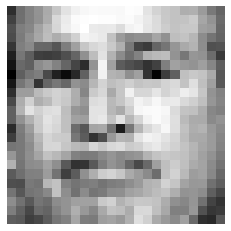

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

img = x[0,::2,::2]
img = img[4:-3,:]

plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

これに次にようにマスクで欠損を入れたデータを用意する：

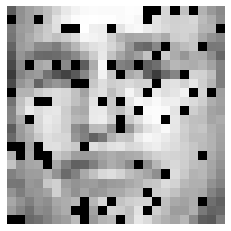

In [4]:
h, w = img.shape
M = np.ones(w*w)

idxes = np.random.choice(list(range(w*w)),64 )
M[idxes]=0
M = M.reshape((w,w))

X = M*img/255

plt.imshow(X, cmap='gray')
plt.axis("off")
plt.show()

この欠損画像は、非負値行列因子分解で次のように補完される

In [5]:
W = np.random.rand(h, w)
H = np.random.rand(h, w)

for _ in range(1000):
    W, H = nmf_update(X, W, H, M)

補完後の画像`W@H`は

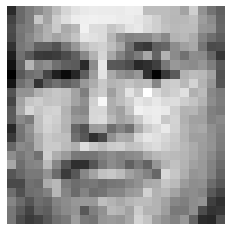

In [6]:
plt.imshow(W@H, cmap='gray')
plt.axis("off")
plt.show()

補われたピクセルだけを表示して見ると

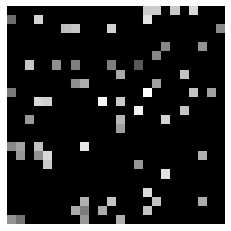

In [7]:
plt.imshow((1-M)*(W@H), cmap='gray')
plt.axis("off")
plt.show()

# 欠損値なしの時の非負行列因子分解

簡単な欠損値なしの場合に`X=W@H`を解くのは、簡単にsklearnが使える。今度はLFWデータセット全体の計画行列を行列因子分解しよう：

In [8]:
n, h, w = x[:,::2,::2].shape
x_train = x[:,::2,::2].reshape((n, h*w))/255

print(x_train.shape)

(1140, 744)


In [31]:
from sklearn.decomposition import NMF

# model = NMF(n_components=32)
# model = NMF(n_components=32)
model = NMF(n_components=6)

W = model.fit_transform(x_train)
H = model.components_

この結果得られた`W2H`を計算しておこう

In [32]:
x_train_reconst = W@H
x_train_reconst = x_train_reconst.reshape((n, h, w))

行列因子分解で再構成された画像を一枚見て見る

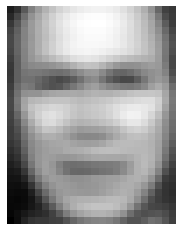

In [33]:
plt.imshow(x_train_reconst[0], cmap='gray')
plt.axis("off")
plt.show()

一方本当の画像は

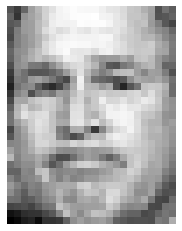

In [34]:
plt.imshow(x[0,::2,::2], cmap='gray')
plt.axis("off")
plt.show()

Hの成分を可視化して見ると

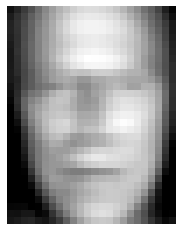

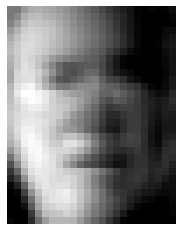

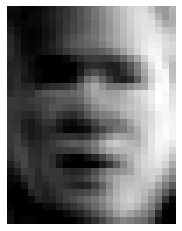

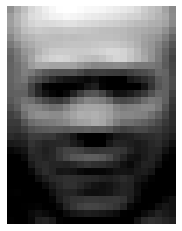

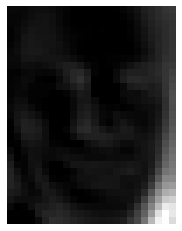

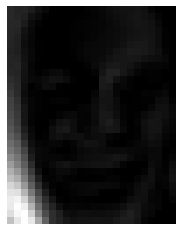

In [36]:
for d in range(6):
    h_d = H[d,:]
    plt.imshow(h_d.reshape((h,w)), cmap='gray')
    plt.axis("off")
    plt.show()

一方で今再構成したインスタンスに対応する係数`W`は

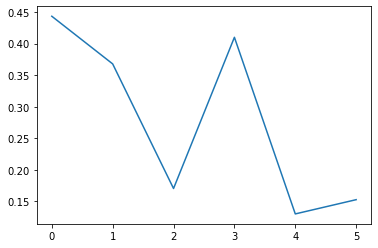

In [37]:
plt.plot(W[1])